# **Chargement des données**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyspark 
from pyspark.sql import SparkSession

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 14.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=2856025123d6a46d585824a5c99f0a08847c87fb784c055270247851ac8cf5e6
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [3]:
spark = SparkSession.builder.appName("ProjectBigData").getOrCreate()

In [4]:
df = spark.read.option("header",True).csv("/content/drive/MyDrive/Memoire/latestdata_0.csv")
print(df)

DataFrame[ID: string, age: string, sex: string, city: string, province: string, country: string, latitude: string, longitude: string, geo_resolution: string, date_onset_symptoms: string, date_admission_hospital: string, date_confirmation: string, symptoms: string, lives_in_Wuhan: string, travel_history_dates: string, travel_history_location: string, reported_market_exposure: string, additional_information: string, chronic_disease_binary: string, chronic_disease: string, source: string, sequence_available: string, outcome: string, date_death_or_discharge: string, notes_for_discussion: string, location: string, admin3: string, admin2: string, admin1: string, country_new: string, admin_id: string, data_moderator_initials: string, travel_history_binary: string]


In [5]:
df.show()

+--------------------+----+---------+--------------+---------+---------+----------+------------------+--------------+-------------------+-----------------------+-----------------+--------+--------------+--------------------+-----------------------+------------------------+----------------------+----------------------+---------------+--------------------+------------------+--------------------+-----------------------+--------------------+-----------+------+--------------+---------+-----------+--------+-----------------------+---------------------+
|                  ID| age|      sex|          city| province|  country|  latitude|         longitude|geo_resolution|date_onset_symptoms|date_admission_hospital|date_confirmation|symptoms|lives_in_Wuhan|travel_history_dates|travel_history_location|reported_market_exposure|additional_information|chronic_disease_binary|chronic_disease|              source|sequence_available|             outcome|date_death_or_discharge|notes_for_discussion|   loc

# **Nettoyage des données**

In [6]:
df.groupby(['outcome']).count().show()

+--------------------+------+
|             outcome| count|
+--------------------+------+
|     Under treatment|   370|
|                null|992688|
|                Dead|    13|
|               Death|     4|
|            Deceased|  5011|
|        Hospitalized|202424|
|               Alive|   189|
|               death|    47|
|              stable|   154|
|treated in an int...|     2|
|           recovered|  3657|
|    not hospitalized|     2|
|              severe|     2|
|critical conditio...|     2|
|  critical condition|     1|
|          discharged|   110|
|released from qua...|     4|
|Discharged from h...|     4|
|Symptoms only imp...|     2|
|                died|   916|
+--------------------+------+
only showing top 20 rows



In [7]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import when

df1 = df.withColumn('outcome', 
                    when(df.outcome.endswith('death'), regexp_replace(df.outcome, 'death', 'dead'))
                    .when(df.outcome.endswith('Dead'), regexp_replace(df.outcome, 'Dead', 'dead'))
                    .when(df.outcome.endswith('died'), regexp_replace(df.outcome, 'died', 'dead'))
                    .when(df.outcome.endswith('Deceased'), regexp_replace(df.outcome, 'Deceased', 'dead'))
                    .when(df.outcome.endswith('Died'), regexp_replace(df.outcome, 'Died', 'dead'))
                    .when(df.outcome.endswith('Death'), regexp_replace(df.outcome, 'Death', 'dead'))
                    .when(df.outcome.endswith('Discharged'), regexp_replace(df.outcome, 'Discharged','discharged'))
                    .when(df.outcome.endswith('Alive'), regexp_replace(df.outcome, 'Alive','discharged'))
                    .when(df.outcome.endswith('Discharged from hospital'), regexp_replace(df.outcome, 'Discharged from hospital','discharged'))
                    .when(df.outcome.endswith('Recovered'), regexp_replace(df.outcome, 'Recovered','discharged'))
                    .when(df.outcome.endswith('recovered'), regexp_replace(df.outcome, 'recovered','discharged'))
                    .when(df.outcome.endswith('discharge'), regexp_replace(df.outcome, 'discharge','discharged'))
                    .when(df.outcome.endswith('recovering at home 03.03.2020'), regexp_replace(df.outcome, 'recovering at home 03.03.2020','discharged'))
                    .when(df.outcome.endswith('released from quarantine'), regexp_replace(df.outcome, 'released from quarantine','discharged'))
                    .when(df.outcome.endswith('not hospitalized'), regexp_replace(df.outcome, 'not hospitalized','discharged'))
                    .otherwise(df.outcome))

df1.groupby(['outcome']).count().show()

+--------------------+------+
|             outcome| count|
+--------------------+------+
|     Under treatment|   370|
|                null|992688|
|        Hospitalized|202424|
|              stable|   154|
|treated in an int...|     2|
|              severe|     2|
|critical conditio...|     2|
|  critical condition|     1|
|          discharged| 97787|
|Symptoms only imp...|     2|
|https://www.mspbs...|   126|
|              España|     7|
|              Stable|    31|
|      severe illness|     1|
|  Critical condition|     1|
|            Migrated|     5|
|    stable condition|   133|
| Receiving Treatment|   257|
|      Migrated_Other|     8|
|                dead|  5998|
+--------------------+------+
only showing top 20 rows



In [8]:
df1 = df1.na.fill({"outcome": "discharged"})
df1.groupby(['outcome']).count().show()

+--------------------+-------+
|             outcome|  count|
+--------------------+-------+
|     Under treatment|    370|
|        Hospitalized| 202424|
|              stable|    154|
|treated in an int...|      2|
|              severe|      2|
|critical conditio...|      2|
|  critical condition|      1|
|          discharged|1090475|
|Symptoms only imp...|      2|
|https://www.mspbs...|    126|
|              España|      7|
|              Stable|     31|
|      severe illness|      1|
|  Critical condition|      1|
|            Migrated|      5|
|    stable condition|    133|
| Receiving Treatment|    257|
|      Migrated_Other|      8|
|                dead|   5998|
|            unstable|      1|
+--------------------+-------+



In [9]:
li = ["dead", "discharged"]
df1 = df1.filter( df1.outcome.isin(li))

df1.groupby(['outcome']).count().show()

+----------+-------+
|   outcome|  count|
+----------+-------+
|discharged|1090475|
|      dead|   5998|
+----------+-------+



In [10]:
df1.groupby(['sex']).count().show()

+----------+------+
|       sex| count|
+----------+------+
|      null|844768|
|    female|132690|
|     death|     1|
|    stable|     2|
| recovered|     2|
|discharged|     7|
|      male|118989|
| discharge|    14|
+----------+------+



In [11]:
li = ["female", "male"]
df1 = df1.na.fill({"sex": "female"})
df1 = df1.filter( df1.sex.isin(li))
df1.groupby(['sex']).count().show()

+------+------+
|   sex| count|
+------+------+
|female|977458|
|  male|118989|
+------+------+



In [12]:
df1.groupby(['travel_history_binary']).count().sort(['count']).show()

+---------------------+-------+
|travel_history_binary|  count|
+---------------------+-------+
|                 True|  30408|
|                 null|  65770|
|                False|1000269|
+---------------------+-------+



In [13]:
li = ["no", "yes"]
df1 = df1.na.fill({"lives_in_Wuhan": "no"})
df1 = df1.filter( df1.lives_in_Wuhan.isin(li))
df1.groupby(['lives_in_Wuhan']).count().show()

+--------------+-------+
|lives_in_Wuhan|  count|
+--------------+-------+
|            no|1095852|
|           yes|    544|
+--------------+-------+



In [14]:
from pyspark.sql.types import IntegerType,BooleanType,DateType, FloatType

df1 = df1.withColumn("age",df1.age.cast(IntegerType()))
df1 = df1.withColumn("lives_in_Wuhan",df1.lives_in_Wuhan.cast(BooleanType()))
df1 = df1.withColumn("latitude",df1.latitude.cast(FloatType()))
df1 = df1.withColumn("longitude",df1.longitude.cast(FloatType()))
df1 = df1.withColumn("admin_id",df1.admin_id.cast(FloatType()))
df1 = df1.withColumn("chronic_disease_binary",df1.chronic_disease_binary.cast(BooleanType()))
df1 = df1.withColumn("travel_history_binary",df1.travel_history_binary.cast(BooleanType()))
df1 = df1.withColumn("date_onset_symptoms",df1.date_onset_symptoms.cast(DateType()))
df1 = df1.withColumn("date_admission_hospital",df1.date_onset_symptoms.cast(DateType()))
df1 = df1.withColumn("date_confirmation",df1.date_onset_symptoms.cast(DateType()))
df1 = df1.withColumn("date_death_or_discharge",df1.date_onset_symptoms.cast(DateType()))

In [15]:
from pyspark.sql.functions import length
from pyspark.sql.functions import mean

df1 = df1[df1["age"].contains("/") == False]
df1 = df1[df1["age"].contains("-") == False]
df1 = df1[length(df1["age"]) < 3]
meanAge = df1.select(mean("age")).collect()[0][0]
df1 = df1.na.fill({"age": meanAge})
df1 = df1.withColumn('sex', 
                    when(df1.sex.endswith('female'), regexp_replace(df1.sex, 'female', "0"))
                    .when(df1.sex.endswith('male'), regexp_replace(df1.sex, 'male', "1"))
                    .otherwise(df1.sex))
df1 = df1.withColumn("sex",df1.sex.cast(IntegerType()))
df1 = df1.na.fill({"longitude": df1.select(mean("longitude")).collect()[0][0]})
df1 = df1.na.fill({"latitude": df1.select(mean("latitude")).collect()[0][0]})
df1 = df1.na.fill({"city": "Quezon"})
df1 = df1.na.fill({"province": "Metro Manila"})
df1 = df1.na.fill({"country": "Philippines"})
df1 = df1.na.fill({"geo_resolution": "point"})
df1 = df1.na.fill({"symptoms": "fever"})
df1 = df1.na.fill({"chronic_disease_binary": False})
df1 = df1.na.fill({"travel_history_binary": False})
df1 = df1.na.fill({"chronic_disease": "hypertension"})
df1 = df1.na.fill({"location": "Jaipur"})
df1 = df1.na.fill({"admin3": "Lixian County"})
df1 = df1.na.fill({"admin2": "Wuhan City"})
df1 = df1.na.fill({"admin1": "Delhi"})
df1 = df1.na.fill({"country_new": "India"})
df1 = df1.na.fill({"admin_id": "10966.0"})
df1 = df1.withColumn('reported_market_exposure', 
                    when(df1.reported_market_exposure.endswith('yes, retailer in the seafood wholesale market'), regexp_replace(df1.reported_market_exposure, 'yes, retailer in the seafood wholesale market', "1"))
                    .when(df1.reported_market_exposure.endswith('na'), regexp_replace(df1.reported_market_exposure, 'na', "0"))
                    .when(df1.reported_market_exposure.endswith('no'), regexp_replace(df1.reported_market_exposure, 'no', "0"))
                    .otherwise(df1.reported_market_exposure))
df1 = df1.withColumn("reported_market_exposure",df1.reported_market_exposure.cast(IntegerType()))
df1 = df1.na.fill({"reported_market_exposure": 0})
df1 = df1.na.fill({"data_moderator_initials": "TR"})
df1 = df1.withColumn('outcome', 
                    when(df1.outcome.endswith('dead'), regexp_replace(df1.outcome, 'dead', "1"))
                    .when(df1.outcome.endswith('discharged'), regexp_replace(df1.outcome, 'discharged', "0"))
                    .otherwise(df1.outcome))
df1 = df1.withColumn("outcome",df1.outcome.cast(IntegerType()))
df1.show()

+-----------+---+---+--------------------+------------+---------+---------+---------+--------------+-------------------+-----------------------+-----------------+--------+--------------+--------------------+-----------------------+------------------------+----------------------+----------------------+---------------+--------------------+------------------+-------+-----------------------+--------------------+--------------------+-----------------+--------------+------+-----------+--------+-----------------------+---------------------+
|         ID|age|sex|                city|    province|  country| latitude|longitude|geo_resolution|date_onset_symptoms|date_admission_hospital|date_confirmation|symptoms|lives_in_Wuhan|travel_history_dates|travel_history_location|reported_market_exposure|additional_information|chronic_disease_binary|chronic_disease|              source|sequence_available|outcome|date_death_or_discharge|notes_for_discussion|            location|           admin3|        ad

# **Corrélation des données**

In [16]:
dfCorr = df1.drop('ID','date_onset_symptoms', 'date_admission_hospital', 'date_confirmation', 'travel_history_dates', 'travel_history_location', 'source', 'sequence_available', 'date_death_or_discharge','country_new','data_moderator_initials','chronic_disease','admin3','admin2', 'admin1','location', 'additional_information', 'notes_for_discussion', 'city', 'province', 'country', 'geo_resolution', 'symptoms')
dfCorr

DataFrame[age: int, sex: int, latitude: float, longitude: float, lives_in_Wuhan: boolean, reported_market_exposure: int, chronic_disease_binary: boolean, outcome: int, admin_id: float, travel_history_binary: boolean]

In [17]:
from pyspark.sql.functions import col, when, count
dfCorr.select([count(when(col(c).isNull() , c)).alias(c) for c in dfCorr.columns]
   ).show()

+---+---+--------+---------+--------------+------------------------+----------------------+-------+--------+---------------------+
|age|sex|latitude|longitude|lives_in_Wuhan|reported_market_exposure|chronic_disease_binary|outcome|admin_id|travel_history_binary|
+---+---+--------+---------+--------------+------------------------+----------------------+-------+--------+---------------------+
|  0|  0|       0|        0|             0|                       0|                     0|      0|       0|                    0|
+---+---+--------+---------+--------------+------------------------+----------------------+-------+--------+---------------------+



In [18]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=dfCorr.columns, outputCol=vector_col)
df_vector = assembler.transform(dfCorr).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]

In [19]:
corrmatrix = matrix.toArray().tolist()
dfcorrmatrix = spark.createDataFrame(corrmatrix,dfCorr.columns)
dfcorrmatrix.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+----------------------+--------------------+--------------------+---------------------+
|                 age|                 sex|            latitude|           longitude|      lives_in_Wuhan|reported_market_exposure|chronic_disease_binary|             outcome|            admin_id|travel_history_binary|
+--------------------+--------------------+--------------------+--------------------+--------------------+------------------------+----------------------+--------------------+--------------------+---------------------+
|                 1.0|0.003510820752412...| 0.06879386083995176| -0.0965643726443228|0.007525735644632189|    9.831803286545556E-4|   0.05790199200599308| 0.13798993509102578|0.012892816044381014| 0.005870655040534159|
|0.003510820752412...|                 1.0|-0.02775043678417739|-0.01214947854017287|0.002341263906063...|    -0.00435171907

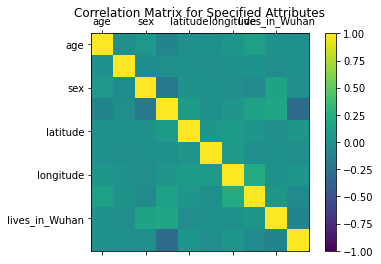

In [20]:
import matplotlib.pyplot as plt

def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, dfCorr.columns, 345)

Les variables les plus corrélées avec la variable "outcome" sont: l'age et la longitude.
En général, si la plupart des coefficients de corrélation sont inférieurs à 0,3 comme notre cas, l'ACP n'aidera pas.

# **Visualisation des données en deux dimensions en passant par l’ACP**

In [21]:
from pyspark.ml.feature import VectorAssembler

vecAssembl = VectorAssembler(inputCols=dfCorr.columns,outputCol='features')
df2 = vecAssembl.transform(dfCorr)

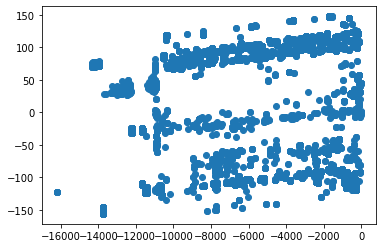

In [22]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(df2)

reslt= pca_model.transform(df2).select("pcaFeatures")
dfvis = reslt.toPandas()
dataX = []
dataY = []
for vec in dfvis.values:
    dataX.extend([vec[0][0]])
    dataY.extend([vec[0][1]])
plt.scatter(dataX, dataY)
plt.show()

D'après la visualisation, il est clair qu'il y a 3 clusters mis en évidence.

L'Analyse des Correspondances Multiples (ACM) est une autre méthode qui permet d'étudier l'association entre au moins deux variables qualitatives. L'Analyse des Correspondances Multiples est aux variables qualitatives ce que l'Analyse en Composantes Principales est aux variables quantitatives.

# **Classification par Arbre de Decision**

In [23]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd

features = dfCorr.drop("outcome")
dfCorr = dfCorr.withColumn("label",col("outcome")) 
va = VectorAssembler(inputCols = features.columns, outputCol='features')

va_df = va.transform(dfCorr)
va_df = va_df.select(['features', 'label'])
va_df.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[78.0,1.0,45.2977...|    1|
|(9,[0,2,3,7],[61....|    0|
|[66.0,1.0,45.9481...|    0|
+--------------------+-----+
only showing top 3 rows



In [24]:
dataframes = va_df.randomSplit([0.7, 0.3], seed=26)
train = dataframes[0]
test = dataframes[1]
train.count()

46129

In [25]:
dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dtc = dtc.fit(train)

pred = dtc.transform(test)
pred.show(3)

+--------------------+-----+---------------+--------------------+----------+
|            features|label|  rawPrediction|         probability|prediction|
+--------------------+-----+---------------+--------------------+----------+
|(9,[0,2,3,7],[1.0...|    0|[14735.0,309.0]|[0.97946024993352...|       0.0|
|(9,[0,2,3,7],[1.0...|    0|[14735.0,309.0]|[0.97946024993352...|       0.0|
|(9,[0,2,3,7],[1.0...|    0|[14735.0,309.0]|[0.97946024993352...|       0.0|
+--------------------+-----+---------------+--------------------+----------+
only showing top 3 rows



In [26]:
from sklearn.metrics import confusion_matrix
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  0.9780860643895387
Confusion Matrix:
[[19274    39]
 [  306    89]]


Nous avons un taux de précision de 0.9778 pour le modele de classification d'arbre de décision.

# **Régression pour la prédiction de l'âge**

La régression linéaire traite des valeurs continues, c'est ainsi que nous avons choisi les variables explicatives suivantes: sex, latitude, longitude, lives_in_Wuhan, reported_market_exposure, chronic_disease_binary, outcome, admin_id, travel_history_binary

In [27]:
features = dfCorr.drop("age")
va = VectorAssembler(inputCols = features.columns, outputCol='features')

va_df = va.transform(dfCorr)
va_df = va_df.select(['features', 'age'])
va_df.show(3)

+--------------------+---+
|            features|age|
+--------------------+---+
|[1.0,45.297748565...| 78|
|(10,[1,2,7],[1.35...| 61|
|(10,[0,1,2,7],[1....| 66|
+--------------------+---+
only showing top 3 rows



In [28]:
dataframes = va_df.randomSplit([0.7, 0.3], seed=26)
train_df = dataframes[0]
test_df = dataframes[1]
train_df.count()

46129

In [29]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='age', maxIter=100, regParam=0.01, elasticNetParam=0.3)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.08391978315206298,0.058973893970270086,-0.02154300143992236,2.4138453591696676,-7.511031516940255,12.142032397373809,9.21352596397153,5.261884612952366e-05,-1.2978898560669232,9.21352596397153]
Intercept: 42.76670100723771


In [30]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 17.523754
r2: 0.036876


Plus le RMSE est bas, mieux un modèle s'ajuste à un ensemble de données et plus la valeur R 2 est élevée, plus un modèle s'adapte à un ensemble de données.
La valeur RMSE dans notre cas nous indique que l'écart moyen entre les ages prévus par le modèle et les ages réels de notre dataset est de 17.52. Et La valeur R2 nous indique que les variables prédictives du modèle sont capables d'expliquer que 3.68% de la variation de l'age.

# **Trois méthodes de clustering**

*   K-means
*   NMF 
*   CAH





***K-means***

In [31]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(df2)
    
    output=KMeans_fit.transform(df2)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.8244470849591324
Silhouette Score: 0.9194018861844606
Silhouette Score: 0.9266722988835142
Silhouette Score: 0.8970045298745156
Silhouette Score: 0.8829729353016377
Silhouette Score: 0.8744372566590244
Silhouette Score: 0.8235378417622728
Silhouette Score: 0.8352838294351268


Text(0, 0.5, 'cost')

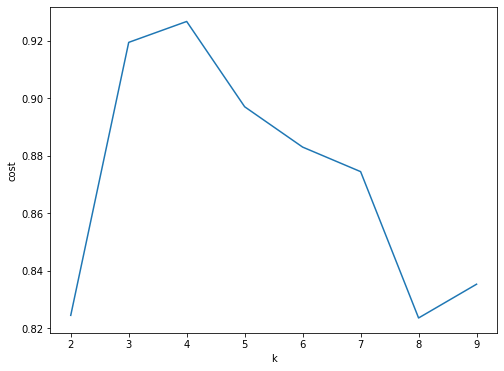

In [32]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

Nous voyons que le score de la silhouette est maximisé à k = 4. Nous prendrons donc 4 clusters.

In [33]:
KMeans_=KMeans(featuresCol='features', k=4) 
KMeans_Model=KMeans_.fit(df2)
KMeans_transform=KMeans_Model.transform(df2)

# **NMF**

In [34]:
from pyspark.ml.recommendation import ALS
dfCorr = dfCorr.withColumn("user",col("admin_id"))
dfCorr = dfCorr.withColumn("item",col("age"))
dfCorr = dfCorr.withColumn("rating",col("outcome")) 

In [35]:
from pyspark.ml.evaluation import RegressionEvaluator

als = ALS(rank=5, maxIter=5, alpha = 1.0, nonnegative=True, seed=123456789)
model = als.fit(dfCorr)
testDF = model.transform(dfCorr).select("prediction","outcome")

# Calcul du RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="outcome",
                            predictionCol="prediction")
rmse = evaluator.evaluate(testDF)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.13148229135322526


# **CAH**

In [36]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette')
for K in range(2,11):

    BKMeans_=BisectingKMeans(featuresCol='features', k=K, minDivisibleClusterSize =1)

    BKMeans_fit=BKMeans_.fit(df2)

    BKMeans_transform=BKMeans_fit.transform(df2) 

    evaluation_score=evaluator.evaluate(BKMeans_transform)

    silhouette_scores.append(evaluation_score)

Text(0, 0.5, 'Silhouette Score')

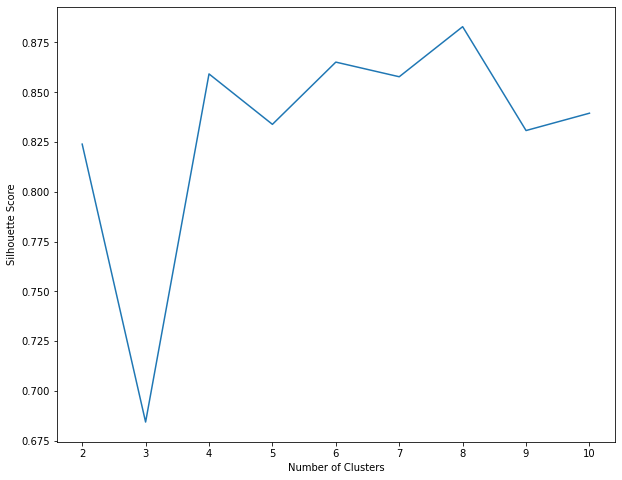

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

Nous voyons que le score de la silhouette pour ce modele est maximisé à k = 8. Mais a toujours un bon score pour 4 clusters.

In [38]:
BKMeans_=BisectingKMeans(featuresCol='features', k=8) 
BKMeans_Model=BKMeans_.fit(df2)
BKMeans_transform=BKMeans_Model.transform(df2)

# **Visualisation des models**

Kmeans

In [39]:
import numpy as np
pca_transformed = pca_model.transform(df2)
X_pca = pca_transformed.rdd.map(lambda row: row.pcaFeatures).collect()
X_pca = np.array(X_pca)

In [40]:
cluster_assignment = np.array(KMeans_transform.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

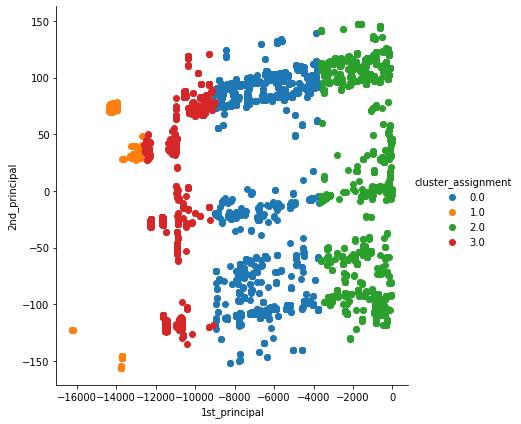

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((X_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
plt.show()

NMF

In [42]:
cluster_assignment = np.array(testDF.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

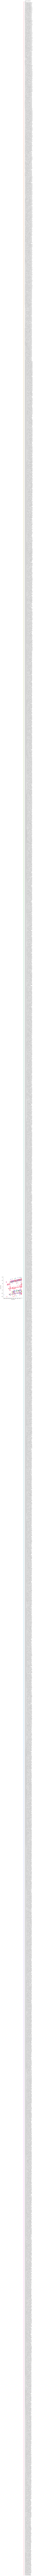

In [43]:
pca_data = np.hstack((X_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
plt.show()

CAH

In [44]:
cluster_assignment = np.array(BKMeans_transform.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

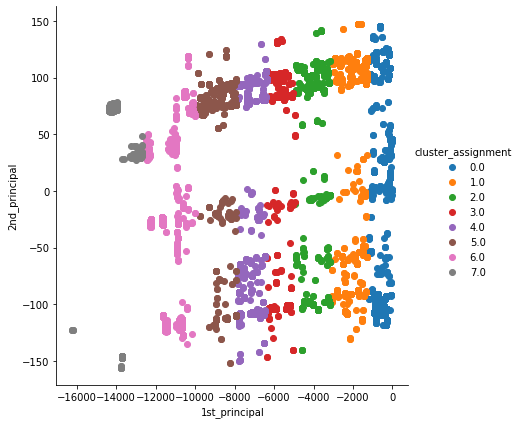

In [45]:
pca_data = np.hstack((X_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()
plt.show()

Si nous extrayons aléatoirement des échantillons équilibrés, nous réduirons ainsi le risque que notre algorithme d'apprentissage automatique penche vers la majorité. Parce que sans rééchantillonnage, nous pourront trouver le paradoxe de la précision où nous exécutont un modèle de classification avec une précision de 90 %.

# **Gestion déséquilibre entre les classes**

In [46]:
dfCorr.select("outcome").groupby(['outcome']).count().show()

+-------+-----+
|outcome|count|
+-------+-----+
|      1| 1333|
|      0|64504|
+-------+-----+



In [47]:
major_df = dfCorr.filter(col("outcome") == 0)
minor_df = dfCorr.filter(col("outcome") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 48


la classe (discharged) 0 a 64504 exemples, tandis que la classe (dead) 1 n'a que 1333 exemples. Nous pouvons sous-échantillonner la classe 0 ou suréchantillonner la classe 1. Le rapport est de 48.

Sous-échantillonnage

In [48]:
sampled_majority_df = major_df.sample(False, 1/ratio)
combined_df = sampled_majority_df.unionAll(minor_df)
combined_df.show()

+---+---+---------+----------+--------------+------------------------+----------------------+-------+--------+---------------------+-----+-------+----+------+
|age|sex| latitude| longitude|lives_in_Wuhan|reported_market_exposure|chronic_disease_binary|outcome|admin_id|travel_history_binary|label|   user|item|rating|
+---+---+---------+----------+--------------+------------------------+----------------------+-------+--------+---------------------+-----+-------+----+------+
| 37|  1| 47.36667|      8.55|         false|                       0|                 false|      0| 10186.0|                false|    0|10186.0|  37|     0|
| 67|  1| -34.6033|  -58.3817|         false|                       0|                 false|      0|  1790.0|                false|    0| 1790.0|  67|     0|
| 49|  1|  44.4325|  26.10389|         false|                       0|                 false|      0|  1783.0|                false|    0| 1783.0|  49|     0|
| 37|  1| 30.70291|  103.8256|         false| 

In [49]:
combined_df.select("outcome").groupby(['outcome']).count().show()

+-------+-----+
|outcome|count|
+-------+-----+
|      0| 1391|
|      1| 1333|
+-------+-----+



Essayons de refaire l'arbre de décision avec nos données équilibrées

In [50]:
features = combined_df.drop("outcome")
combined_df = combined_df.withColumn("label",col("outcome")) 
va = VectorAssembler(inputCols = features.columns, outputCol='features')

va_df = va.transform(combined_df)
va_df = va_df.select(['features', 'label'])
dataframes = va_df.randomSplit([0.7, 0.3], seed=26)
train_df = dataframes[0]
test_df = dataframes[1]

dtc = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dtc = dtc.fit(train_df)

pred = dtc.transform(test_df)
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction")
acc = evaluator.evaluate(pred)
 
print("Prediction Accuracy: ", acc)
 
y_pred=pred.select("prediction").collect()
y_orig=pred.select("label").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Prediction Accuracy:  1.0
Confusion Matrix:
[[430   0]
 [  0 406]]


Nous constatons ici une meilleure précision des prédictions.

Maintenant la prédiction de l'age

In [51]:
features = combined_df.drop("age")
va = VectorAssembler(inputCols = features.columns, outputCol='features')

va_df = va.transform(combined_df)
va_df = va_df.select(['features', 'age'])
va_df.show(3)

+--------------------+---+
|            features|age|
+--------------------+---+
|(13,[0,1,2,7,10,1...| 37|
|(13,[0,1,2,7,10,1...| 67|
|(13,[0,1,2,7,10,1...| 49|
+--------------------+---+
only showing top 3 rows



In [52]:
dataframes = va_df.randomSplit([0.7, 0.3], seed=26)
train_df = dataframes[0]
test_df = dataframes[1]
train_df.count()

1888

In [53]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='age', maxIter=100, regParam=0.01, elasticNetParam=0.3)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0012771045957809255,0.0,0.0,0.0012771045957812642,0.0,0.999424191694091,0.0012771045957828237]
Intercept: 0.02863210662976861


In [54]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.010141
r2: 1.000000


La valeur RMSE dans ce cas indique que l'écart moyen entre les ages prévus par le modèle et les ages réels de notre dataset est de 0.01, largement plus petit que le RMSE des données déséquilibrées. Et La valeur R2 indique que les variables prédictives du modèle sont capables d'expliquer 100% de la variation de l'age. Nous Constatons ici qu'avec des données équilibrées notre model apprend mieux.

# **ML Tuning**

CrossValidator commence par diviser l'ensemble de données en un ensemble de plis qui sont utilisés comme ensembles de données d'apprentissage et de test distincts. Par exemple, avec k = 3 fois, CrossValidator générera 3 paires d'ensembles de données (formation, test), chacune utilisant 2/3 des données pour la formation et 1/3 pour les tests. Pour évaluer une ParamMap particulière, CrossValidator calcule la métrique d'évaluation moyenne pour les 3 modèles produits en ajustant l'estimateur sur les 3 paires de jeux de données différentes (apprentissage, test).

Après avoir identifié la meilleure ParamMap, CrossValidator réadapte enfin l'Estimator en utilisant la meilleure ParamMap et l'ensemble des données.

# **Avantages Utilisation Spark**

Spark est un cadre de calcul distribué dont l'abstraction principale est RDD. Spark est à usage général et peut être utilisé pour une grande variété de choses, du traitement SQL à une variété d'algorithmes d'apprentissage automatique. Apache +MLib nous offre une solution évolutive pour une variété d'algorithmes ML. Spark est plus évolutif en ce qui concerne la taille d'un nœud donné par rapport à TensorFlow par exemple.

Spark ML a été construit de manière à avoir une utilisation proche de scikit-learn. Scikit-learn dispose de nombreux packages selon le type d’algorithme, alors que Spark ML propose un même et unique package (exemple: "Tunning") regroupant tous les algorithmes dédiés à cette tâche(exemple: CrossValidator, TrainValidationSplit, ParamGridBuilder).

Lorsque nous avons des ensembles de données vraiment volumineux comme dans notre cas, il est préférable d'utiliser Spark pour traiter nos données, et ML Lib/ML pour y faire du machine learning.